In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [2]:

def center_crop(image, target_size=(512, 512)):
    center_x, center_y = image.size[0] // 2, image.size[1] // 2
    half_width, half_height = target_size[0] // 2, target_size[1] // 2
    return image.crop((center_x - half_width, center_y - half_height, center_x + half_width, center_y + half_height))

train_dataset = []
labels = np.concatenate([np.full(40, i) for i in range(0, 5)], axis=0)

folder_path = "../Dataset/"
n = 1
i = 1
li = 0
while (i < 251): 
    if (n == 40): 
        i += 10
        n = 0
    img = Image.open(f"{folder_path}{i}.jpg")
    img = center_crop(img)
    img = np.array(img) 
    if img.shape == (512, 512, 3):
        train_dataset.append(img)
    else :
        labels = np.delete(labels, li)
    n += 1
    i += 1
    li += 1

print(len(train_dataset))
print(len(labels))

199
199


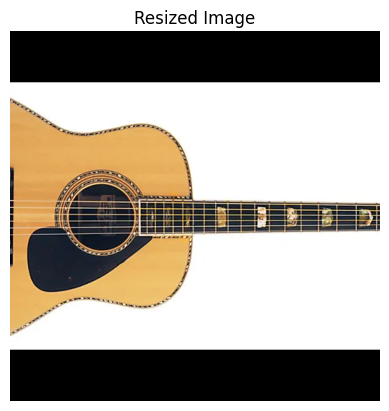

In [3]:
plt.imshow(train_dataset[33])
plt.axis('off')  # Hide the axis for a cleaner look
plt.title("Resized Image")
plt.show()

In [4]:
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 512, 512)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (32, 256, 256)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 128, 128)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (128, 64, 64)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: (256, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (256, 32, 32)
        )
    def forward(self, x):
      return self.feature_extractor(x)

extractor = FeatureExtractor()

batch_size = 32 
train_dataset = np.array(train_dataset)
dataset_tensor = torch.tensor(train_dataset, dtype=torch.float32).permute(0, 3, 1, 2)
features_tensor = []

In [5]:
with torch.no_grad():
    for i in range(0, len(dataset_tensor), batch_size):
        batch = dataset_tensor[i:i+batch_size]
        f = extractor(batch)  # Pass the batch through the network
        features_tensor.append(f)
        del batch, f


In [6]:
features_tensor = torch.cat(features_tensor, dim=0)
features = np.array(features_tensor)
features.shape


/tmp/ipykernel_17654/2991877804.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  features = np.array(features_tensor)


(199, 256, 32, 32)

In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size 

        np.random.seed(42)
        
        # Initialize weights
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)

        # Initialize the biases
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.bias_output = np.zeros((1, self.output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True)) 
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def feedforward(self, X):
        # Input to hidden
        self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_activation)

        # Hidden to output
        self.output_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.softmax(self.output_activation)

        return self.predicted_output

    def backward(self, X, y, learning_rate):
        # Compute the output layer error
        output_error = y - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        # Compute the hidden layer error
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

        # Update weights and biases
        self.weights_hidden_output += np.dot(self.hidden_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += np.dot(X.T, hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
             
            # Calculate loss (cross-entropy)
            loss = -np.sum(y * np.log(output)) / X.shape[0]
            
            predictions = np.argmax(output, axis=1) 
            labels = np.argmax(y, axis=1) 
            accuracy = np.mean(predictions == labels)

            # Print the loss and accuracy
            print(f"Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy * 100:.2f}%")


In [8]:
features_flattened = features_tensor.reshape(features_tensor.shape[0], -1)

labels_one_hot = np.zeros((labels.shape[0], 5))
labels_one_hot[np.arange(labels.shape[0]), labels] = 1

input_size = features_flattened.shape[1]  
hidden_size = 356 
output_size = 5  

nn = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Train the network
epochs = 1000
learning_rate = 0.01
nn.train(features_flattened, labels_one_hot, epochs=epochs, learning_rate=learning_rate)


/tmp/ipykernel_17654/1652940518.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
/tmp/ipykernel_17654/1652940518.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_17654/1652940518.py:50: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.weights_input_hidden += np.dot(X.T, hidden_delta) * learning_rate


Epoch 0, Loss: 16.023351861702427, Accuracy: 17.59%
Epoch 1, Loss: 13.516633936110953, Accuracy: 16.58%
Epoch 2, Loss: 12.180793952554971, Accuracy: 17.09%
Epoch 3, Loss: 11.274019882589105, Accuracy: 19.60%
Epoch 4, Loss: 10.503863424244171, Accuracy: 17.59%
Epoch 5, Loss: 9.940460820603189, Accuracy: 18.59%
Epoch 6, Loss: 9.31106183000676, Accuracy: 18.09%
Epoch 7, Loss: 8.625432454700888, Accuracy: 17.59%
Epoch 8, Loss: 8.241265815208376, Accuracy: 16.08%
Epoch 9, Loss: 7.776019280285785, Accuracy: 16.08%
Epoch 10, Loss: 7.42801902182664, Accuracy: 17.59%
Epoch 11, Loss: 7.367104833598767, Accuracy: 19.10%
Epoch 12, Loss: 7.086054440836824, Accuracy: 19.60%
Epoch 13, Loss: 6.8342341141508784, Accuracy: 21.61%
Epoch 14, Loss: 6.736381985362109, Accuracy: 21.11%
Epoch 15, Loss: 6.598915531199562, Accuracy: 20.60%
Epoch 16, Loss: 6.563234218142599, Accuracy: 19.10%
Epoch 17, Loss: 6.495253306432028, Accuracy: 19.60%
Epoch 18, Loss: 6.451396137134762, Accuracy: 20.10%
Epoch 19, Loss: 6.

In [20]:
test_dataset = []
test_labels = np.concatenate([np.full(10, i) for i in range(0, 5)], axis=0)
i = 40
li = 0
while (i<251): 
    img =  Image.open(f"{folder_path}{i}.jpg")
    img = np.array(center_crop(img))
    if(img.shape == (512,512,3)):
        test_dataset.append(img)
    else: 
        test_labels = np.delete(test_labels,li)
    n = n+1
    i+=1
    li+=1
    if(n == 10): 
        i +=40
        n = 0

print(len(test_dataset))
print(len(test_labels))


49
49


In [21]:
test_dataset = np.array(test_dataset)
test_dataset_tensor = torch.tensor(test_dataset, dtype=torch.float32).permute(0, 3, 1, 2)

features_test_tensor = []

with torch.no_grad():
    for i in range(0, len(test_dataset_tensor), batch_size):
        batch = test_dataset_tensor[i:i + batch_size]
        f = extractor(batch)  # Pass the batch through the feature extractor
        features_test_tensor.append(f)

features_test_tensor = torch.cat(features_test_tensor, dim=0)
features_test_tensor = features_test_tensor.reshape(features_test_tensor.shape[0], -1)


In [22]:
predictions = nn.feedforward(features_test_tensor)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

test_labels_one_hot = np.zeros((test_labels.shape[0], 5))
test_labels_one_hot[np.arange(test_labels.shape[0]), test_labels] = 1

accuracy = np.mean(predicted_classes == np.argmax(test_labels_one_hot, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/tmp/ipykernel_17654/1652940518.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden


[0 4 4 4 0 0 3 3 4 4 1 3 4 1 1 1 1 1 1 1 2 2 2 2 2 2 3 4 4 0 3 1 1 1 3 3 3
 4 3 3 0 0 3 2 4 4 3 4 0]
Test Accuracy: 53.06%


/tmp/ipykernel_17654/1652940518.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


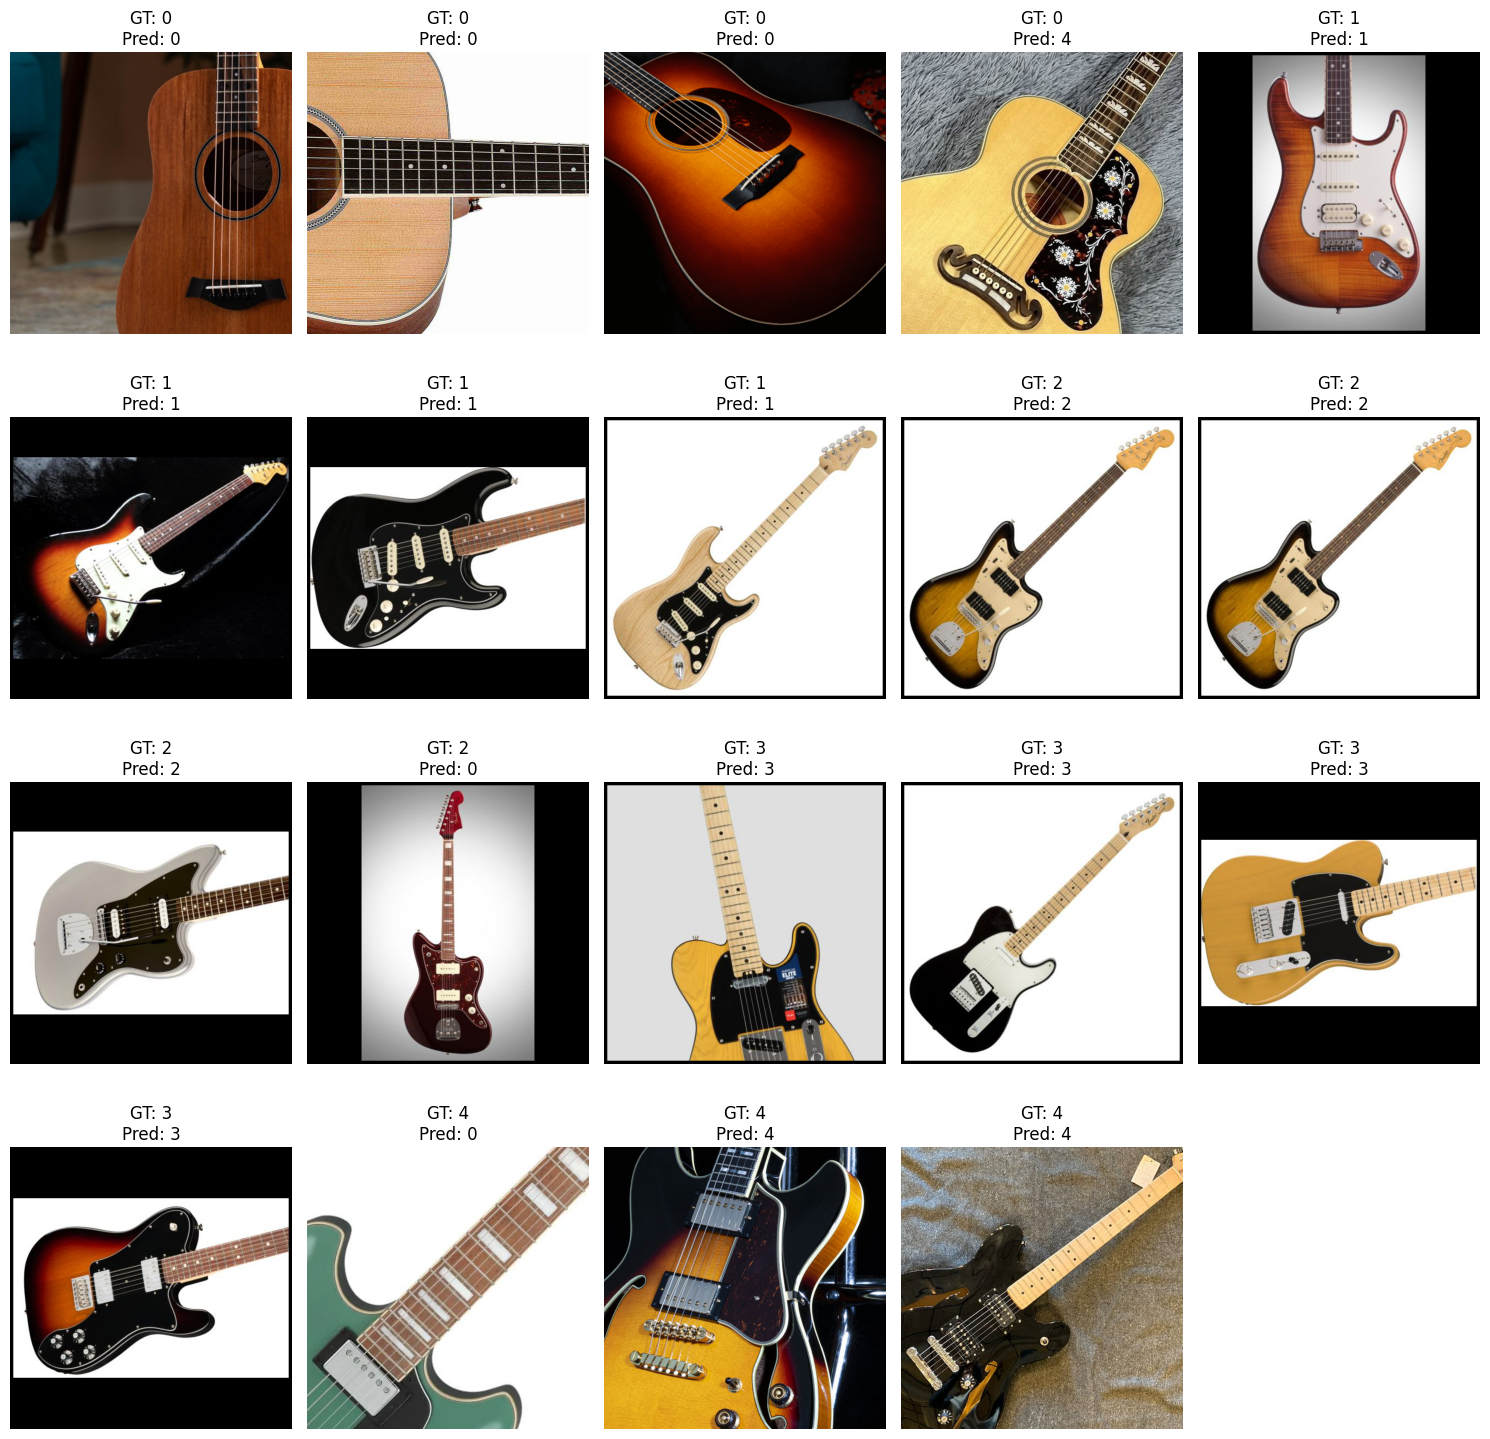

In [19]:
plt.figure(figsize=(15, 15)) 
j = 0
num_samples = 20  
cols = 5  
rows = (num_samples + cols - 1) // cols  

for i in range(num_samples):
    if j >= len(test_dataset): 
        break
    plt.subplot(rows, cols, i + 1)
    plt.imshow(test_dataset[j])
    plt.axis('off')
    plt.title(f"GT: {test_labels[j]}\nPred: {predicted_classes[j]}")
    
    if i % 2 == 0:
        j += 4
    else: 
        j += 1

plt.tight_layout()
plt.show()